In [1]:
import os
import os.path
from itertools import chain
from collections import OrderedDict

import skimage.io
import skimage.color
import skimage.transform
from skimage import filters
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


class Picture:
    def __init__(self, filename, ground_filename):
        self.filename = filename
        self.ground_filename = ground_filename
        self.img = skimage.io.imread(filename)
        #self.ground_img = skimage.color.rgb2gray(skimage.io.imread(filename))
        gimg = skimage.io.imread(ground_filename)
        self.ground_img = skimage.transform.resize(gimg, self.img.shape[:2], mode='constant')
        self.features = OrderedDict()
        
        
CHANNELS = ('R', 'G', 'B')

## 1.2.1 Read the data

In [2]:
def files_from_directory(dirname):
    files = []
    for n in os.listdir(dirname):
        files.append(Picture(
            os.path.join(dirname, n),
            os.path.join('data/horses/figure_ground', n),
        ))
    return files


test_pictures = files_from_directory('data/horses/test')
train_pictures = files_from_directory('data/horses/training')

## 1.2.2 Compute Features

In [3]:
for i in chain(test_pictures, train_pictures):
    i.features['gaussian'] = np.ndarray(i.img.shape)
    i.features['laplace'] = np.ndarray(i.img.shape)
    i.features['median'] = np.ndarray(i.img.shape)
    for c in range(3):
        i.features['gaussian'][:, :, c] = filters.gaussian(i.img[:, :, c])
        i.features['laplace'][:, :, c] = filters.laplace(i.img[:, :, c])
        i.features['median'][:, :, c] = filters.median(i.img[:, :, c])

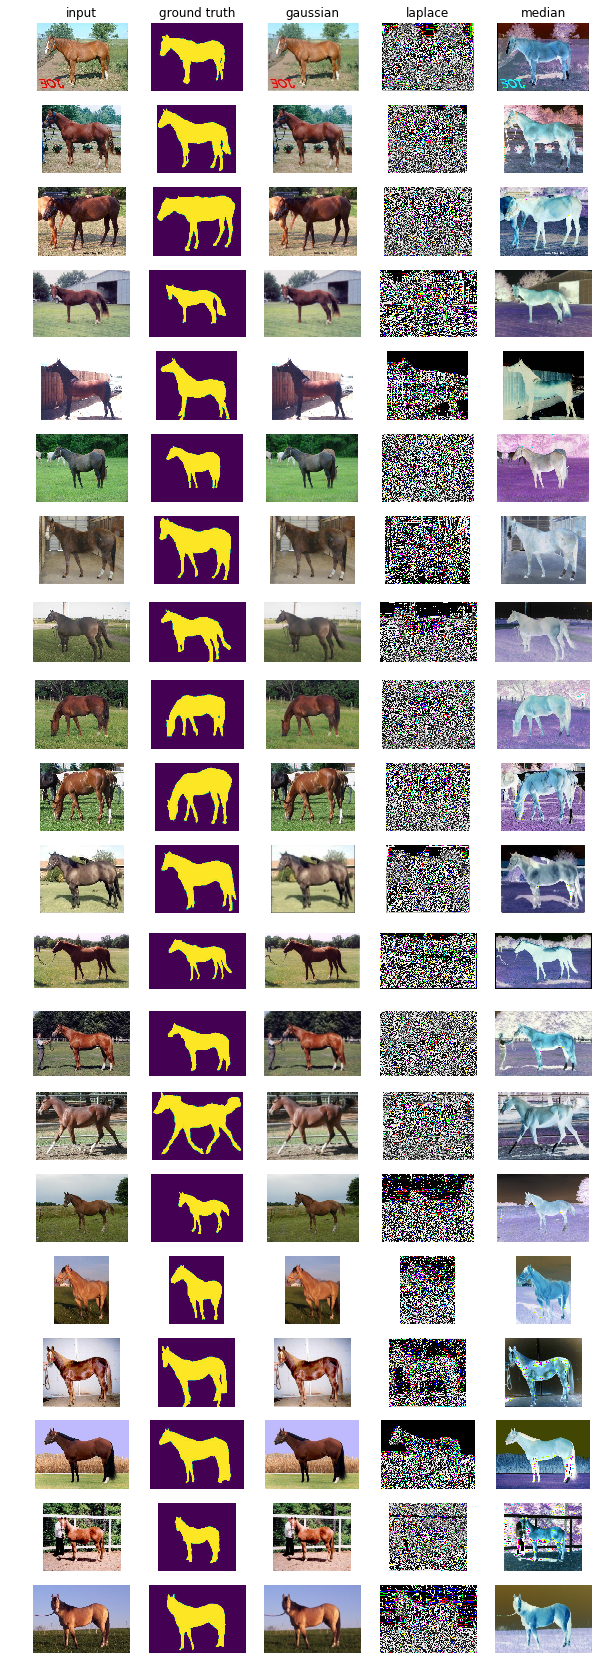

In [4]:
def plot_features(pictures):
    fig, ax = plt.subplots(len(pictures), 2 + len(pictures[0].features), figsize=(10, 30))
    for i, p in enumerate(pictures):
        ax[i, 0].imshow(p.img)
        ax[i, 0].axis('off')
        ax[i, 1].imshow(p.ground_img)
        ax[i, 1].axis('off')
        if i == 0:
            ax[i, 0].set_title('input')
            ax[i, 1].set_title('ground truth')
        for j, v in enumerate(p.features.items()):
            if i == 0:
                ax[i, j + 2].set_title(v[0])
            ax[i, j + 2].imshow(v[1])
            ax[i, j + 2].axis('off')
            pass
    plt.show()
        
plot_features(test_pictures + train_pictures)

## 1.2.3 Random Forest

In [5]:
X = np.ndarray((sum([p.img.shape[0] * p.img.shape[1] for p in train_pictures]), 3 * (len(train_pictures[0].features) + 1)))
X[:, 0:3] = np.concatenate([p.img.reshape((p.img.shape[0] * p.img.shape[1], 3)) for p in train_pictures])

for i, k in enumerate(train_pictures[0].features.keys()):
    X[:, i + 1:i + 4] = np.concatenate([p.features[k].reshape((p.img.shape[0] * p.img.shape[1], 3)) for p in train_pictures])
    
y = np.concatenate([p.ground_img.flatten() for p in train_pictures]) == 1.0

In [6]:
clf = RandomForestClassifier(n_estimators=25)
clf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=25, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [23]:
for p in test_pictures:
    x = np.ndarray((p.img.shape[0] * p.img.shape[1], 3 * (len(p.features) + 1)))
    x[:, 0:3] = p.img.reshape((p.img.shape[0] * p.img.shape[1], 3))
    for i, k in enumerate(p.features.keys()):
        x[:, i + 1:i+4] = p.features[k].reshape((p.img.shape[0] * p.img.shape[1], 3))
    p.prediction = clf.predict(x)

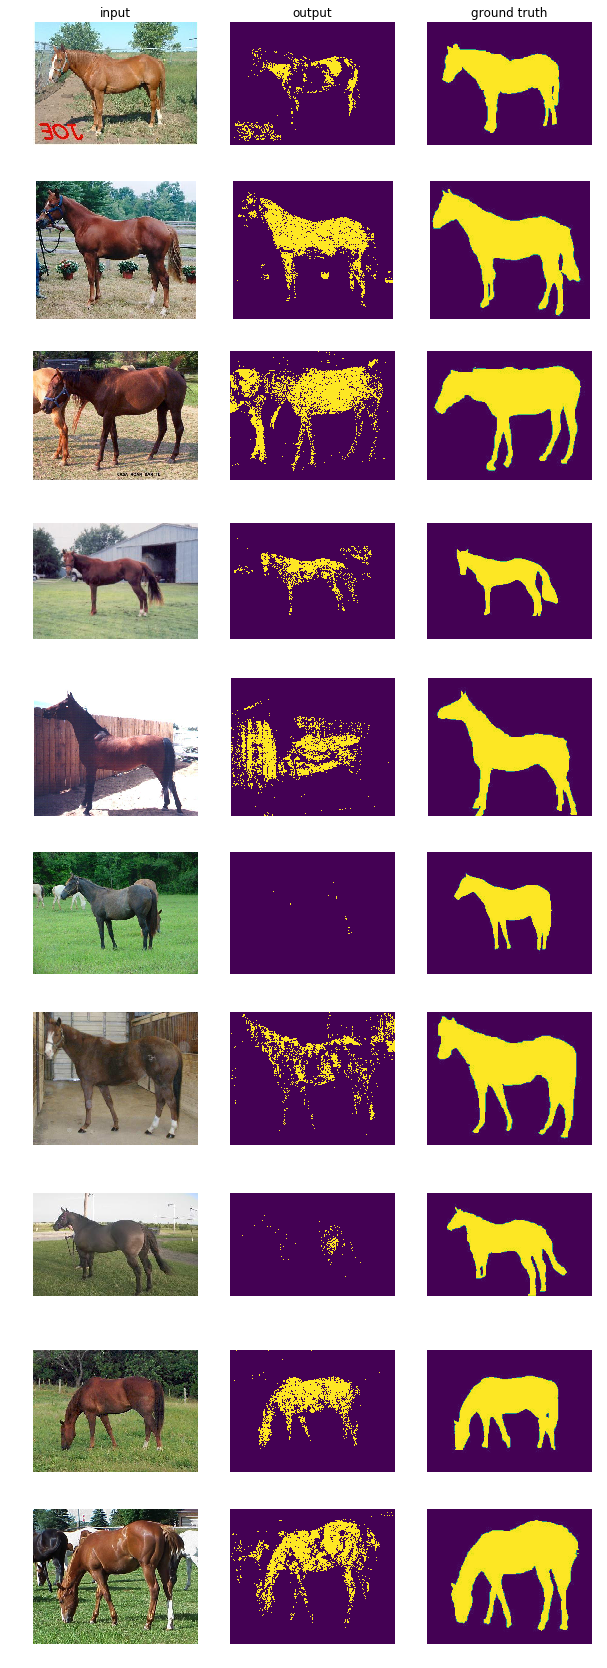

In [27]:
def plot_predictions(pictures):
    fig, ax = plt.subplots(len(pictures), 3, figsize=(10, 30))
    ax[0, 0].set_title('input')
    ax[0, 1].set_title('output')
    ax[0, 2].set_title('ground truth')
    for i, p in enumerate(pictures):
        ax[i, 0].imshow(p.img)
        ax[i, 0].axis('off')
        ax[i, 1].imshow(p.prediction.reshape(p.img.shape[:2]))
        ax[i, 1].axis('off')
        ax[i, 2].imshow(p.ground_img)
        ax[i, 2].axis('off')
    plt.show()
    
plot_predictions(test_pictures)

In [25]:
_x = np.asanyarray(x)
(_x.dtype.char in np.typecodes['AllFloat'], not np.isfinite(_x.sum()),
            not np.isfinite(_x).all())

(True, False, False)